In [1]:
import os
# Dataset from: https://www.cs.toronto.edu/~kriz/cifar.html
data_folder = os.path.join(os.path.expanduser("~"), "Data", "cifar-10-batches-py")
batch1_filename = os.path.join(data_folder, "data_batch_1")

In [2]:
import pickle
# Bigfix thanks to: http://stackoverflow.com/questions/11305790/pickle-incompatability-of-numpy-arrays-between-python-2-and-3
def unpickle(filename):
    with open(filename, 'rb') as fo:
        return pickle.load(fo, encoding='latin1')

In [3]:
batch1 = unpickle(batch1_filename)

In [4]:
image_index = 100
image = batch1['data'][image_index]

In [5]:
image = image.reshape((32,32, 3), order='F')
import numpy as np
image = np.rot90(image, -1)

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

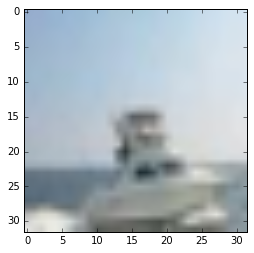

In [7]:
plt.imshow(image)

## Application

In [8]:
import numpy as np
batches = []
for i in range(1, 6):
    batch_filename = os.path.join(data_folder, "data_batch_{}".format(i))
    batches.append(unpickle(batch1_filename))
    break    #IMPORTANT -- see chapter for explanation of this line

In [9]:
X = np.vstack([batch['data'] for batch in batches])

In [10]:
X = np.array(X) / X.max()
X = X.astype(np.float32)

In [11]:
from sklearn.preprocessing import OneHotEncoder
y = np.hstack(batch['labels'] for batch in batches).flatten()
y = OneHotEncoder().fit_transform(y.reshape(y.shape[0],1)).todense()
y = y.astype(np.float32)

In [12]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

In [13]:
X_train = X_train.reshape(-1, 3, 32, 32)
X_test = X_test.reshape(-1, 3, 32, 32)

In [14]:
from lasagne import layers
layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('conv3', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('hidden5', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ]

In [15]:
from nolearn.lasagne import NeuralNet
from lasagne.nonlinearities import sigmoid, softmax

nnet = NeuralNet(layers=layers,
                 input_shape=(None, 3, 32, 32),
                 conv1_num_filters=32,
                 conv1_filter_size=(3, 3),
                 conv2_num_filters=64,
                 conv2_filter_size=(2, 2),
                 conv3_num_filters=128,
                 conv3_filter_size=(2, 2),
                 pool1_pool_size=(2,2),  # Updated from book's version due to code change
                 pool2_pool_size=(2,2),  # Updated from book's version due to code change
                 pool3_pool_size=(2,2),  # Updated from book's version due to code change
                 hidden4_num_units=500,
                 hidden5_num_units=500,
                 output_num_units=10,
                 output_nonlinearity=softmax,
                 update_learning_rate=0.01,
                 update_momentum=0.9,
                 regression=True,
                 max_epochs=3,
                 verbose=1)

In [16]:
nnet.fit(X_train, y_train)

# Neural Network with 874058 learnable parameters

## Layer information

  #  name     size
---  -------  --------
  0  input    3x32x32
  1  conv1    32x30x30
  2  pool1    32x15x15
  3  conv2    64x14x14
  4  pool2    64x7x7
  5  conv3    128x6x6
  6  pool3    128x3x3
  7  hidden4  500
  8  hidden5  500
  9  output   10

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  ------
      1       0.09003       0.09001      1.00026  21.57s
      2       0.09001       0.08999      1.00023  19.80s
      3       0.08998       0.08997      1.00020  19.41s


NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f2a8e3cd588>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f2a8e3cd4a8>,
     check_input=True, conv1_filter_size=(3, 3), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_scores=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 3, 32, 32),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=3, more_params={},
     objective=<function objective at 0x7f2a8e3cb7b8

In [17]:
from sklearn.metrics import f1_score
y_pred = nnet.predict(X_test)
print(f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

0.0535705967575


/home/rob/anaconda3/envs/LDMbook/lib/python3.4/site-packages/sklearn/metrics/classification.py:756: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/home/rob/anaconda3/envs/LDMbook/lib/python3.4/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


*Maintainer's note:* The relationship between Theano, nolearn and Lasagne is a little tenuous -- they update at different times, off different versions and so on. This code was run with python 3.4 and the following versions of libraries:

* Theano==0.8.1
* nolearn==0.6a0.dev0
* Lasagne==0.2.dev1

For full version numbers, see `requirements.txt`: